In [1]:
import pandas as pd
import optuna
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [2]:
# --- 1. Φόρτωση δεδομένων ---
df = pd.read_csv('../data/XAU_1d_signals_combo_all.csv', index_col='Date', parse_dates=True)
df = df[df['Signal_Combo3'].isin([-1, 1])].copy()
df.dropna(inplace=True)

features = [
    'Close', 'Volume',
    'SMA_20', 'SMA_50', 'SMA_100', 'SMA_200',
    'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200',
    'RSI_14', 'MACD', 'MACD_Signal', 'ATR_14'
]
target = 'Signal_Combo3'

X = df[features]
y = df[target].replace({-1: 0, 1: 1})

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)


In [3]:
# --- 2. Συνάρτηση στόχου για Optuna ---
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return f1_score(y_valid, y_pred, average='weighted')

In [4]:
# --- 3. Εκτέλεση Optuna Study ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-06-21 21:30:39,067] A new study created in memory with name: no-name-c8cd21c6-3598-4d7c-bbf3-0e4843f32b58
/opt/anaconda3/envs/dpenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:30:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-21 21:30:39,545] Trial 0 finished with value: 0.7369135422916278 and parameters: {'learning_rate': 0.06820174332284785, 'max_depth': 6, 'n_estimators': 508, 'subsample': 0.8222270298354741, 'colsample_bytree': 0.7109190635534683}. Best is trial 0 with value: 0.7369135422916278.
/opt/anaconda3/envs/dpenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:30:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I

In [5]:
# --- 4. Καλύτερες παραμέτρους ---
print("\nBest Trial:")
print(study.best_trial)


Best Trial:
FrozenTrial(number=14, state=TrialState.COMPLETE, values=[0.8296291225182338], datetime_start=datetime.datetime(2025, 6, 21, 21, 30, 46, 511833), datetime_complete=datetime.datetime(2025, 6, 21, 21, 30, 46, 766698), params={'learning_rate': 0.2085540996084713, 'max_depth': 10, 'n_estimators': 255, 'subsample': 0.8926129184036733, 'colsample_bytree': 0.6228494196998944}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, trial_id=14, value=None)


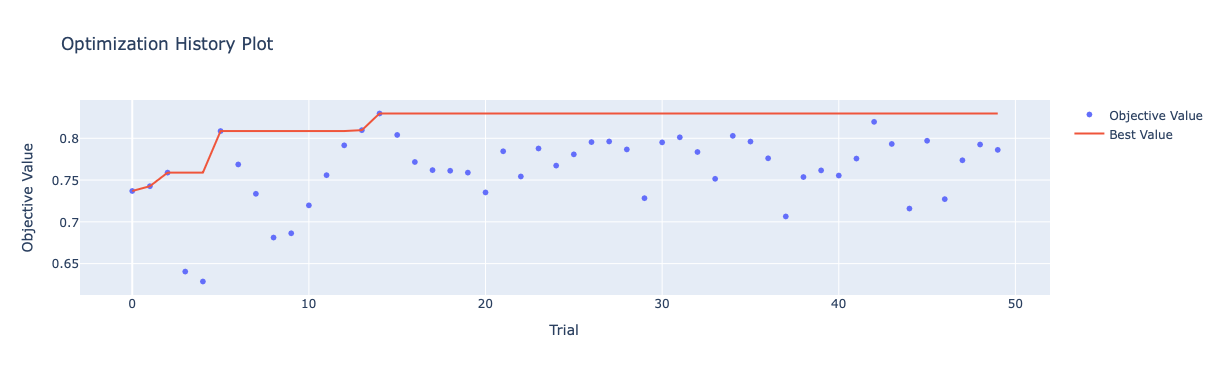

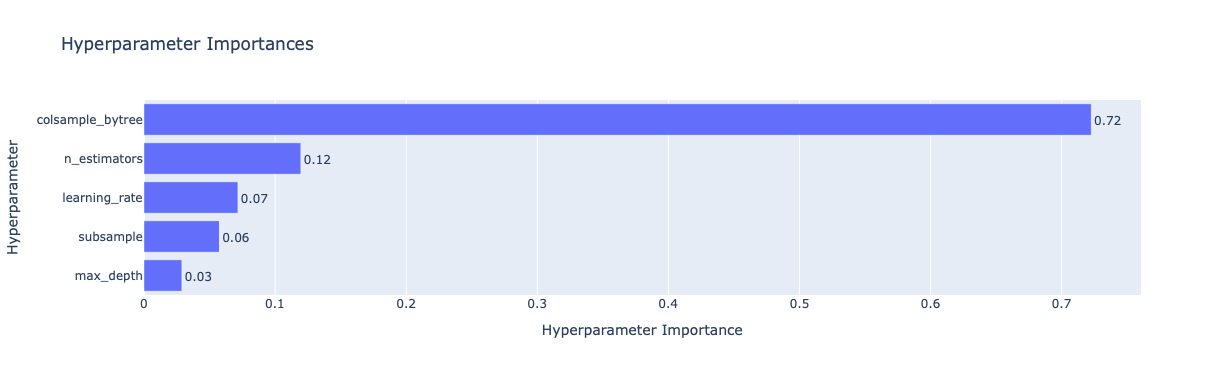

In [6]:
# --- 5. Οπτικοποίηση (προαιρετικά) ---
import optuna.visualization
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

In [7]:
# --- 6. Αποθήκευση του καλύτερου μοντέλου και του Optuna study ---
best_params = study.best_trial.params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
})

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)



/opt/anaconda3/envs/dpenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning:

[21:30:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6228494196998944, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2085540996084713,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=255, n_jobs=None,
              num_parallel_tree=None, ...)

In [8]:
# Αποθήκευση μοντέλου και study
joblib.dump(best_model, '../models/xgboost_combo3_best1.pkl')
joblib.dump(study, '../models/xgboost_combo3_optuna_study.pkl')


['../models/xgboost_combo3_optuna_study.pkl']